In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import tests

## 1. Linear

- Prototype: [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear)
- Location in lib: `modules.layers.Linear`

In [ ]:
tests.test_linear()

## 2. Batch-normalization

- Prototype: [nn.BatchNorm1d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html#torch.nn.BatchNorm1d)
- Location: `modules.layers.BatchNormalization`

In [ ]:
tests.test_bn()

## 3. Dropout

- Prototype: [nn.Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#torch.nn.Dropout)
- Location: `modules.layers.Dropout`

In [ ]:
tests.test_dropout()

## 4. Activation functions

### ReLU

- Prototype: [nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
- Location: `modules.activations.ReLU`

### Sigmoid

- Prototype: [nn.Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html?highlight=nn%20sigmoid#torch.nn.Sigmoid)
- Location: `modules.activations.Sigmoid`

### Softmax

- Prototype: [nn.Softmax](http://bit.ly/get3a)
- Location: `modules.activations.Softmax`

### LogSoftmax

- Prototype: [nn.LogSoftmax](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html?highlight=log%20softmax#torch.nn.LogSoftmax)
- Location: `modules.activations.LogSoftmax`

In [ ]:
tests.test_activations()

## 5. Sequential

- Prototype: [nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)
- Location: `modules.layers.Sequential`

In [ ]:
tests.test_sequential()

## 6. Loss functions

### MSE

- Prototype: [nn.MSELoss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss)
- Location: `modules.criterions.MSELoss`

### Cross Entropy

- Prototype: [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
- Location: `modules.criterions.CrossEntropyLoss`


In [ ]:
tests.test_criterions()

## 7. Optimizers

### SGD

- Prototype: [torch.optim.SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)
- Location: `modules.optimizers.SGD`

### Adam

- Prototype: [torch.optim.Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
- Location: `modules.criterions.CrossEntropyLoss`


In [ ]:
tests.test_optimizers()

## 8. DataLoader

- Prototype: [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)
- Location: `modules.dataloader.DataLoader`

In [ ]:
tests.test_dataloader()

# Test framework on data

In [ ]:
import numpy as np
import modules as mm
from tqdm.notebook import tqdm

## Test on synthetic data

In [ ]:
np.random.seed(42)
X_train = np.random.randn(2048, 8)
X_test = np.random.randn(512, 8)
y_train = np.sin(X_train).sum(axis=1, keepdims=True)
y_test = np.sin(X_test).sum(axis=1, keepdims=True)

train_loader = mm.DataLoader(X_train.astype('float32'), y_train.astype('float32'), batch_size=64, shuffle=True)
test_loader = mm.DataLoader(X_test.astype('float32'), y_test.astype('float32'), batch_size=64, shuffle=False)

model = mm.Sequential(
    mm.Linear(8, 32),
    mm.BatchNormalization(32),
    mm.ReLU(),
    mm.Linear(32, 64),
    mm.Dropout(0.25),
    mm.Sigmoid(),
    mm.Linear(64, 1)
)
optimizer = mm.Adam(model, lr=1e-2)
criterion = mm.MSELoss()

In [ ]:
num_epochs = 100
pbar = tqdm(range(1, num_epochs + 1))

for epoch in pbar:
    train_loss, test_loss = 0.0, 0.0

    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        model.backward(X_batch, criterion.backward(predictions, y_batch))
        optimizer.step()

        train_loss += loss * X_batch.shape[0]

    model.eval()
    for X_batch, y_batch in test_loader:
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        test_loss += loss * X_batch.shape[0]

    train_loss /= train_loader.num_samples()
    test_loss /= test_loader.num_samples()
    pbar.set_postfix({'train loss': train_loss, 'test loss': test_loss})

## MNIST Classification

In [ ]:
import pandas as pd

mnist_df = pd.read_csv('mnist.csv')

In [ ]:
mnist_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X = mnist_df.drop(['label'], axis=1)
y = mnist_df['label']

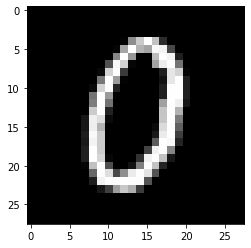

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(X[5:6].values[0].reshape((28, 28)), cmap='gray')

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

Code below will visualize training progress:

In [ ]:
from IPython.display import clear_output

def plot_losses(train_losses, train_metrics, val_losses, val_metrics):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(val_losses) + 1), val_losses, label='val')
    axs[1].plot(range(1, len(train_metrics) + 1), train_metrics, label='train')
    axs[1].plot(range(1, len(val_metrics) + 1), val_metrics, label='val')

    if max(train_losses) / min(train_losses) > 10:
        axs[0].set_yscale('log')

    if max(train_metrics) / min(train_metrics) > 10:
        axs[0].set_yscale('log')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    axs[0].set_ylabel('loss')
    axs[1].set_ylabel('Accuracy')
    plt.show()


def train_and_validate(model, optimizer, criterion, metric, train_loader, val_loader,
                       num_epochs, verbose=True, use_torch = False):
    train_losses, val_losses = [], []
    train_metrics, val_metrics = [], []

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss, running_metric = 0, 0
        pbar = tqdm(train_loader, desc=f'Training {epoch}/{num_epochs}') \
            if verbose else train_loader

        for X_batch, y_batch in pbar:
            
            if use_torch:
                X_batch = torch.from_numpy(X_batch)
                y_batch = torch.from_numpy(y_batch)
            
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            if use_torch:
                loss.backward()
            else:
                model.backward(X_batch, criterion.backward(predictions, y_batch))
            optimizer.step()
            
            metric_value = metric(predictions, y_batch)
            if use_torch:
                loss = loss.item()
                metric_value = metric_value.item()
            running_loss += loss * X_batch.shape[0]
            running_metric += metric_value * X_batch.shape[0]
            if verbose:
                pbar.set_postfix({'loss': loss, 'Accuracy': metric_value})

        train_losses += [running_loss / train_loader.num_samples()]
        train_metrics += [running_metric / train_loader.num_samples()]

        model.eval()
        running_loss, running_metric = 0, 0
        pbar = tqdm(val_loader, desc=f'Validating {epoch}/{num_epochs}') \
            if verbose else val_loader

        for X_batch, y_batch in pbar:
            
            if use_torch:
                X_batch = torch.from_numpy(X_batch)
                y_batch = torch.from_numpy(y_batch)
            
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            
            metric_value = metric(predictions, y_batch)
            if use_torch:
                loss = loss.item()
                metric_value = metric_value.item()
            running_loss += loss * X_batch.shape[0]
            running_metric += metric_value * X_batch.shape[0]
            if verbose:
                pbar.set_postfix({'loss': loss, 'Accuracy': metric_value})

        val_losses += [running_loss / val_loader.num_samples()]
        val_metrics += [running_metric / val_loader.num_samples()]

        if verbose:
            plot_losses(train_losses, train_metrics, val_losses, val_metrics)
    
    if verbose:
        print(f'Validation Accuracy: {val_metrics[-1]:.3f}')
    
    return train_metrics[-1], val_metrics[-1]

## Train and validate

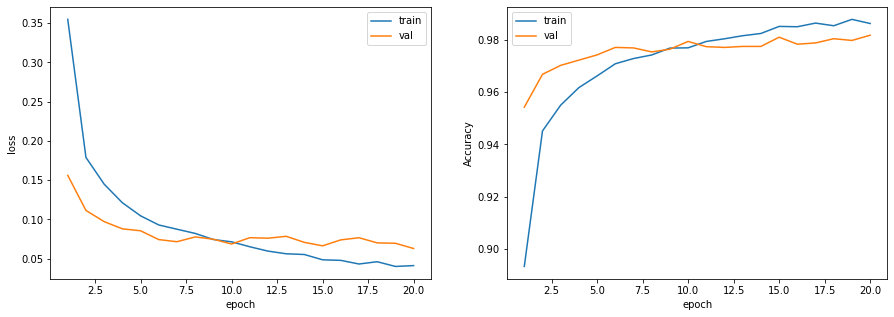

Validation Accuracy: 0.982


In [15]:
IMG_SIZE = 28
NUM_CLASSES = 10
HIDDEN_SIZE = 256
NUM_EPOCHS = 20
BATCH_SIZE = 64

def accuracy(y_pred, y_true):
    return (np.argmax(y_pred, axis=1) == y_true).sum() / y_pred.shape[0]
     
     
model = mm.Sequential(
    # 1
    mm.Linear(in_features=IMG_SIZE**2, out_features=HIDDEN_SIZE),
    mm.BatchNormalization(HIDDEN_SIZE),
    mm.ReLU(),
    mm.Dropout(p=0.2),

    # 2
    mm.Linear(in_features=HIDDEN_SIZE, out_features=HIDDEN_SIZE),
    mm.BatchNormalization(HIDDEN_SIZE),
    mm.ReLU(),
    mm.Dropout(p=0.2),

    # 3
    mm.Linear(in_features=HIDDEN_SIZE, out_features=HIDDEN_SIZE),
    mm.BatchNormalization(HIDDEN_SIZE),
    mm.ReLU(),
    mm.Dropout(p=0.2),

    # 4
    mm.Linear(in_features=HIDDEN_SIZE, out_features=HIDDEN_SIZE),
    mm.BatchNormalization(HIDDEN_SIZE),
    mm.ReLU(),
    mm.Dropout(p=0.2),

    mm.Linear(in_features=HIDDEN_SIZE, out_features=NUM_CLASSES),
)

dataloader_train = mm.DataLoader(X_train.values, y_train.values, batch_size=BATCH_SIZE, shuffle=True)
dataloader_val = mm.DataLoader(X_val.values , y_val.values, batch_size=BATCH_SIZE, shuffle=False)

optimizer = mm.optimizers.Adam(model, lr=1e-3)
criterion = mm.CrossEntropyLoss()
train_metric, val_metric = train_and_validate(model, optimizer, criterion, accuracy, dataloader_train, dataloader_val,
                       NUM_EPOCHS, verbose=True)